In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [18]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Specify the correct encoding directly when reading the file
df = pd.read_csv('IMDb Movies India.csv', encoding='latin-1')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [5]:
df.drop_duplicates(inplace=True)

df.fillna({'Rating': df['Rating'].mean()}, inplace=True)

In [6]:
df['Total Actors'] = df[['Actor 1', 'Actor 2', 'Actor 3']].apply(lambda row: sum(row.notna()), axis=1)

X = df.drop('Rating', axis=1)
y = df['Rating']

In [7]:
X.replace('', np.nan, inplace=True)

In [8]:
missing_values_count = X.isnull().sum()
print("Missing Values:\n", missing_values_count)

Missing Values:
 Name               0
Year             527
Duration        8264
Genre           1876
Votes           7583
Director         524
Actor 1         1615
Actor 2         2381
Actor 3         3140
Total Actors       0
dtype: int64


In [9]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns


In [10]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)

In [12]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('Random Forest', RandomForestRegressor())
]

for name, model in models:
    scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='r2')
    print(f"{name}:")
    print(f"  Cross-validated R-squared: {np.mean(scores):.3f} (+/- {np.std(scores):.3f})")

Linear Regression:
  Cross-validated R-squared: 0.033 (+/- 0.028)
Ridge Regression:
  Cross-validated R-squared: 0.146 (+/- 0.003)
Lasso Regression:
  Cross-validated R-squared: -0.000 (+/- 0.000)
Random Forest:
  Cross-validated R-squared: 0.177 (+/- 0.035)


In [14]:
model.fit(X_train_processed, y_train)
y_pred = model.predict(X_test_processed)

mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"  Mean Squared Error (MSE): {mse:.3f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"  R-squared (R2 Score): {r2:.3f}")
print()

  Mean Squared Error (MSE): 0.763
  Root Mean Squared Error (RMSE): 0.874
  R-squared (R2 Score): 0.217



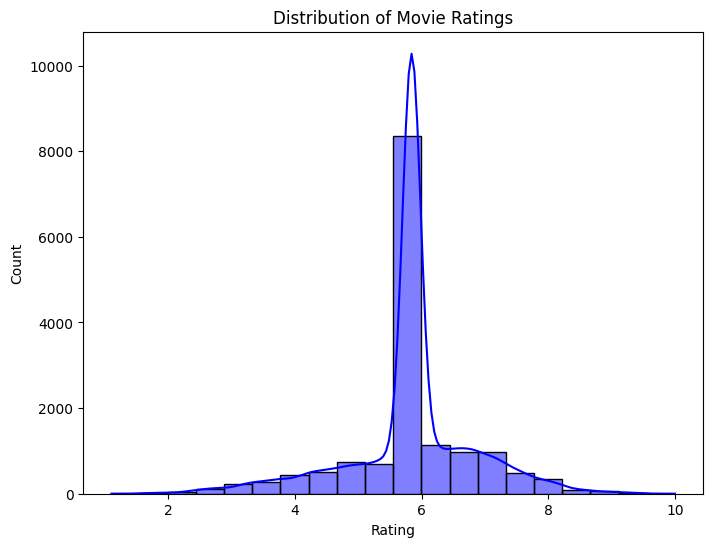

In [15]:
  plt.figure(figsize=(8, 6))
  sns.histplot(df['Rating'], bins=20, kde=True, color='blue', edgecolor='black')
  plt.title('Distribution of Movie Ratings')
  plt.xlabel('Rating')
  plt.ylabel('Count')
  plt.show()

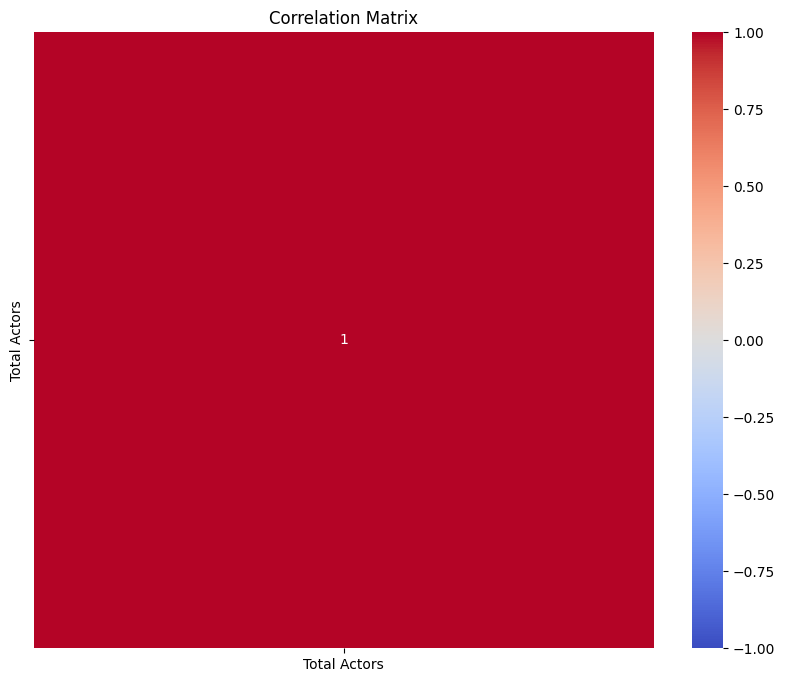

In [16]:
  numeric_data = X_train.select_dtypes(include=['int64', 'float64'])
  corr_matrix = numeric_data.corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title('Correlation Matrix')
  plt.show()

<ipython-input-17-686fdf3ee9c4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[name for name, _ in models], y=[np.mean(cross_val_score(model, X_train_processed, y_train, cv=5, scoring='r2')) for _, model in models], palette='viridis')


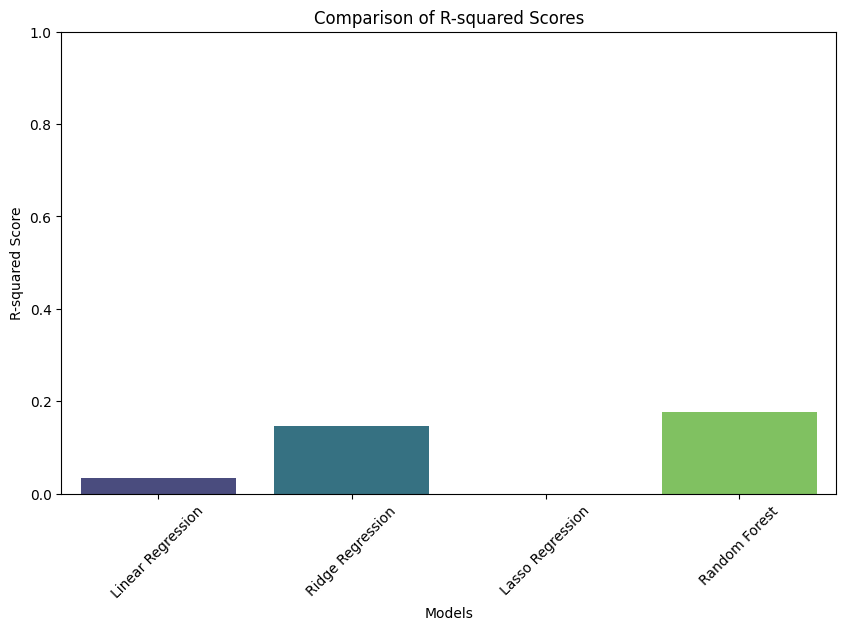

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[name for name, _ in models], y=[np.mean(cross_val_score(model, X_train_processed, y_train, cv=5, scoring='r2')) for _, model in models], palette='viridis')
plt.ylim(0, 1)
plt.title('Comparison of R-squared Scores')
plt.xlabel('Models')
plt.ylabel('R-squared Score')
plt.xticks(rotation=45)
plt.show()

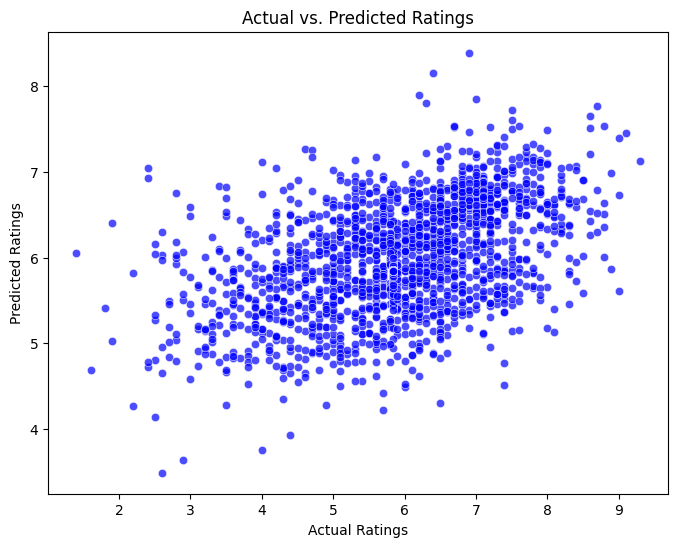

In [19]:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.7)
    plt.title('Actual vs. Predicted Ratings')
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.show()

<ipython-input-22-2b15b9282b16>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=all_feature_names, palette='viridis')


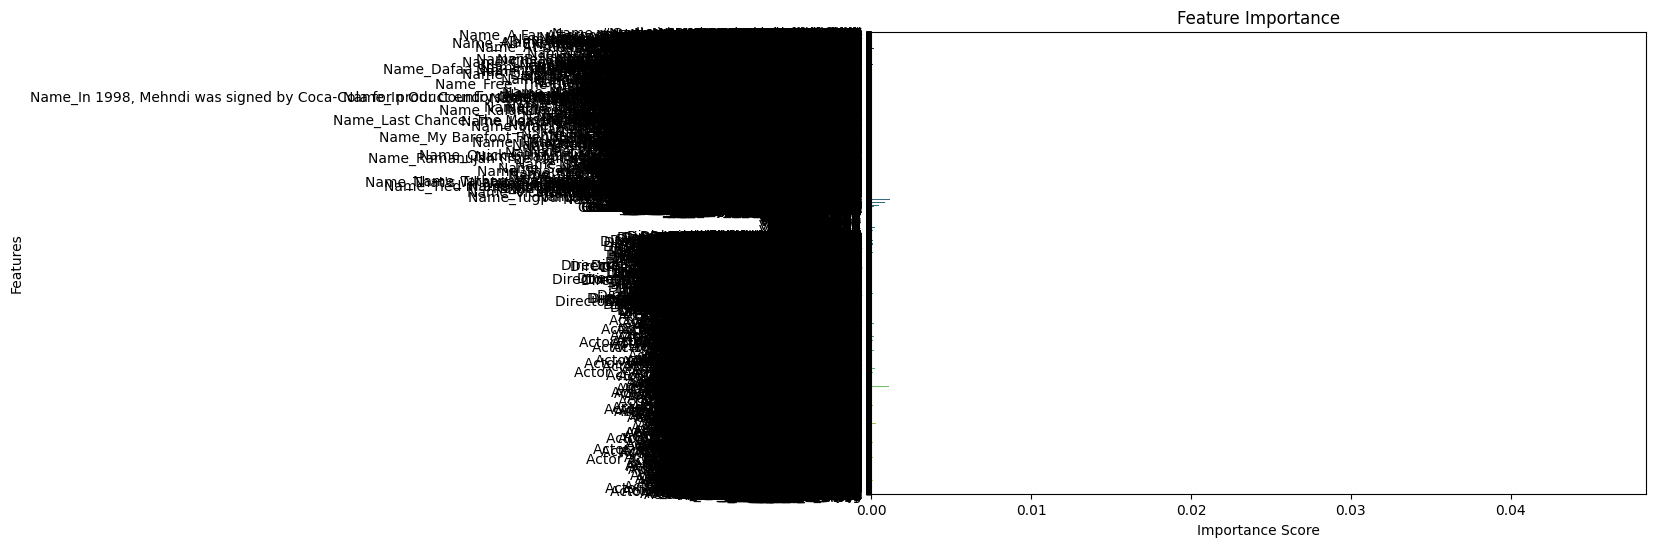

In [22]:
   if isinstance(model, RandomForestRegressor):
    feature_importance = model.feature_importances_
    # Use get_feature_names_out instead of get_feature_names
    feature_names = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(input_features=categorical_features)
    all_feature_names = np.concatenate([numeric_features, feature_names])

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=all_feature_names, palette='viridis')
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

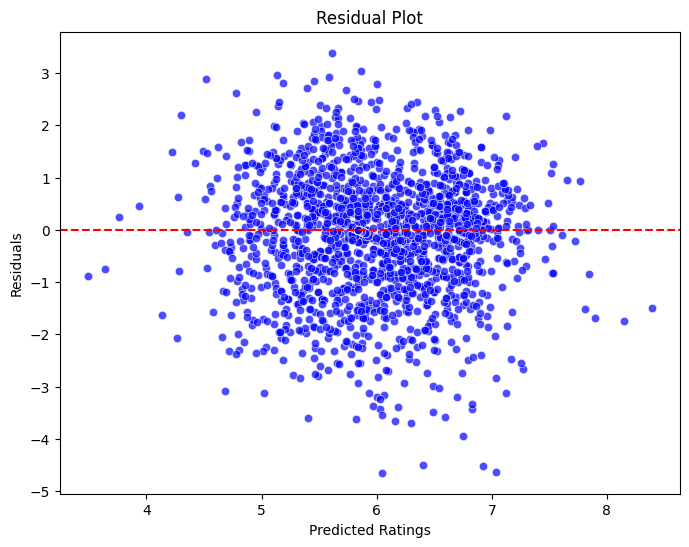

In [23]:
   residuals = y_test - y_pred
   plt.figure(figsize=(8, 6))
   sns.scatterplot(x=y_pred, y=residuals, color='blue', alpha=0.7)
   plt.title('Residual Plot')
   plt.xlabel('Predicted Ratings')
   plt.ylabel('Residuals')
   plt.axhline(y=0, color='red', linestyle='--')
   plt.show()